# Model database fetching and inference

## Load model & set up genome

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from pathlib import Path
import numpy as np
import keras
import crested
import matplotlib.pyplot as plt

In [3]:
# Set the genome
genome_dir = Path("genomes/mm10/")
genome = crested.Genome(genome_dir / "mm10.fa", genome_dir / "mm10.chrom.sizes")
crested.register_genome(genome)

2025-12-09T11:30:09.659683+0100 INFO Genome mm10 registered.


In [4]:
model_path, output_names_biccn = crested.get_model("DeepBICCN")
model_biccn = keras.models.load_model(model_path, compile=False)

## Region predictions and contribution scores

In [5]:
chrom, start, end = "chr3", 72535878, 72536378
midpoint = (start+end)//2
start_resized, end_resized = midpoint - 2114//2, midpoint + 2114//2
sequence = genome.fetch(chrom, start_resized, end_resized)

prediction = crested.tl.predict(sequence, model_biccn)

I0000 00:00:1765276213.789931 2220732 service.cc:145] XLA service 0x147e8c003970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765276213.789959 2220732 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1765276214.995256 2220732 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


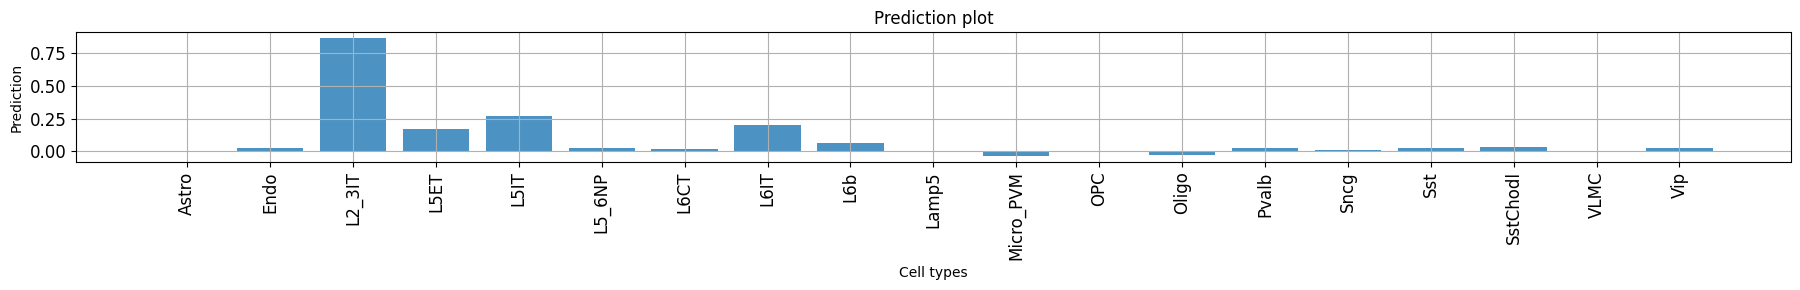

In [6]:
%matplotlib inline
crested.pl.region.bar(prediction, classes=output_names_biccn, xtick_rotation=90)

In [7]:
classes_of_interest = output_names_biccn[np.argmax(prediction)]
class_idx = np.argmax(prediction)

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,
    model=model_biccn,
    batch_size=32,
)

2025-12-09T11:30:16.106086+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:28<00:00, 28.88s/it]


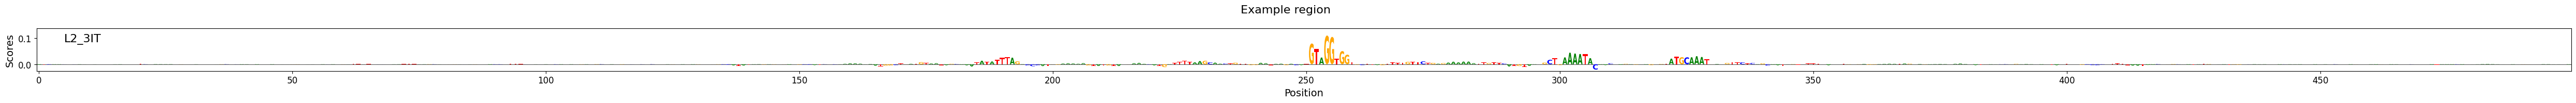

In [8]:
%matplotlib inline
crested.pl.explain.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Example region",
)  # zoom in on the center 500bp

### Same region with another model

In [9]:
model_path, output_names_dmb3 = crested.get_model("DeepMouseBrain3")
model_dmb3 = keras.models.load_model(model_path, compile=False)

In [10]:
prediction = crested.tl.predict(sequence, model_dmb3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/lustre1/project/stg_00002/lcb/cblaauw/python_modules/CREsted/src/crested/pl/_utils.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


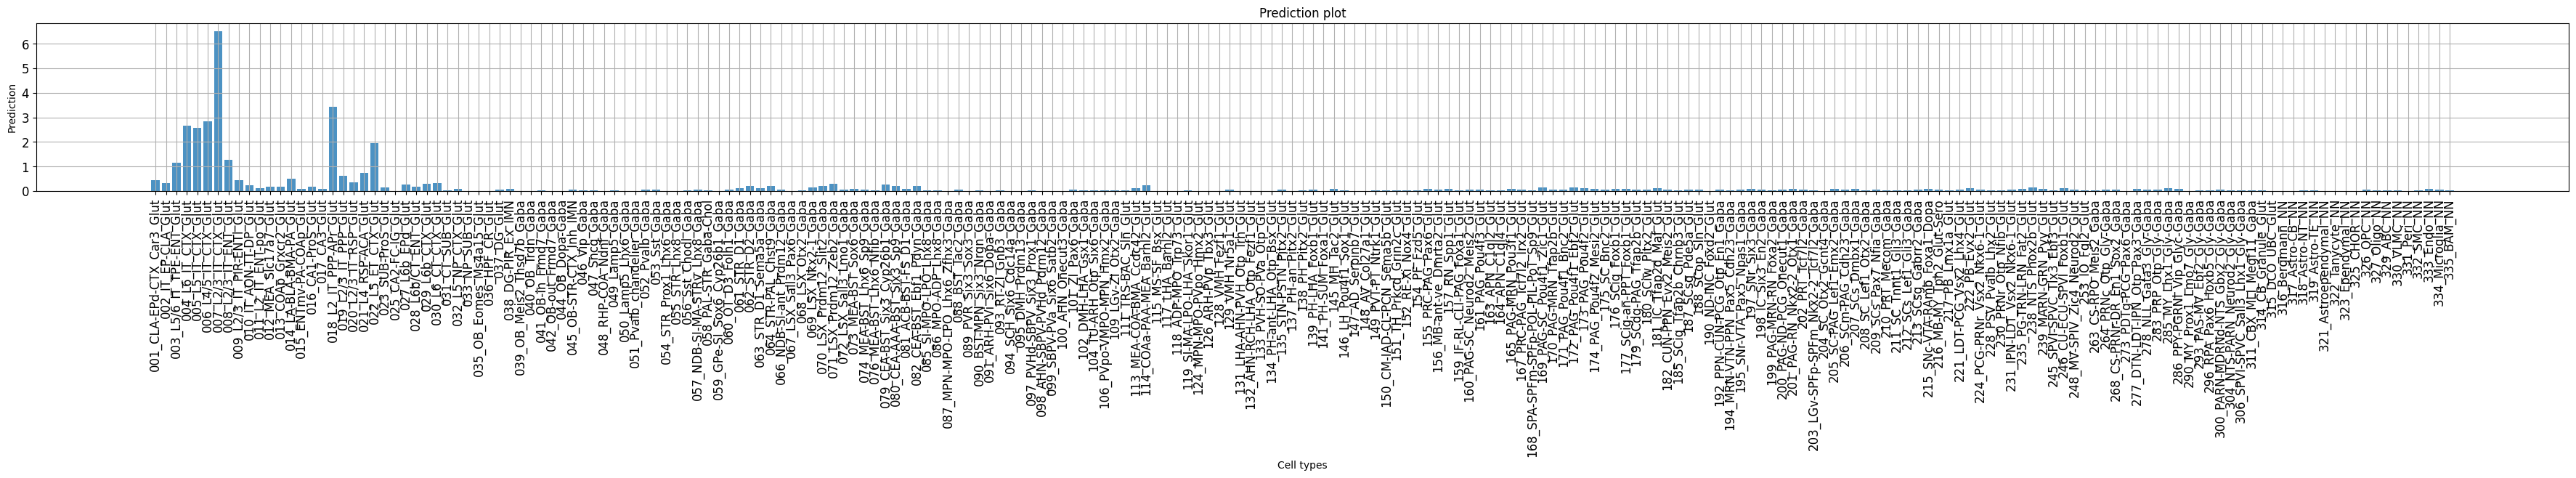

In [11]:
crested.pl.region.bar(prediction, classes=output_names_dmb3, xtick_rotation=90, width=45)

In [12]:
classes_of_interest = output_names_dmb3[np.argmax(prediction)]
class_idx = np.argmax(prediction)

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,
    model=model_dmb3,
    batch_size=32,
)

2025-12-09T11:30:52.803497+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [01:49<00:00, 109.24s/it]


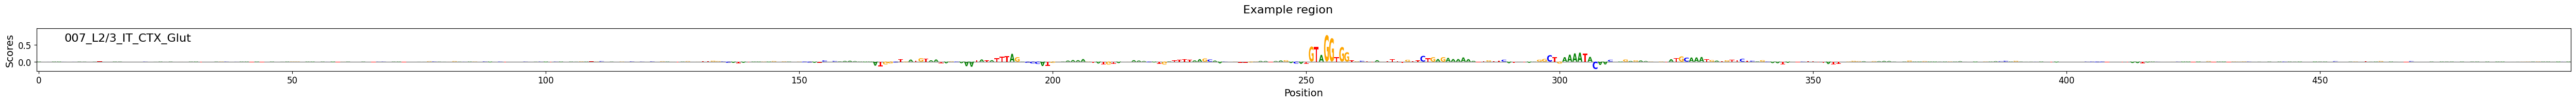

In [13]:
%matplotlib inline
crested.pl.explain.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Example region",
)

## Track predictions

In [14]:
model_path, output_names_bp = crested.get_model("borzoiprime_mouse_rep0")
model_bp = keras.models.load_model(model_path, compile=False)

In [15]:
start_borzoi, end_borzoi = midpoint - 524288//2, midpoint + 524288//2
start_borzoi_output, end_borzoi_output = midpoint - 196608//2, midpoint + 196608//2
sequence_borzoi = genome.fetch(chrom, start_borzoi, end_borzoi)
prediction = crested.tl.predict(sequence_borzoi, model_bp)

I0000 00:00:1765276385.335377 2221017 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_49', 20 bytes spill stores, 12 bytes spill loads

I0000 00:00:1765276386.247713 2221016 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_49', 16 bytes spill stores, 16 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


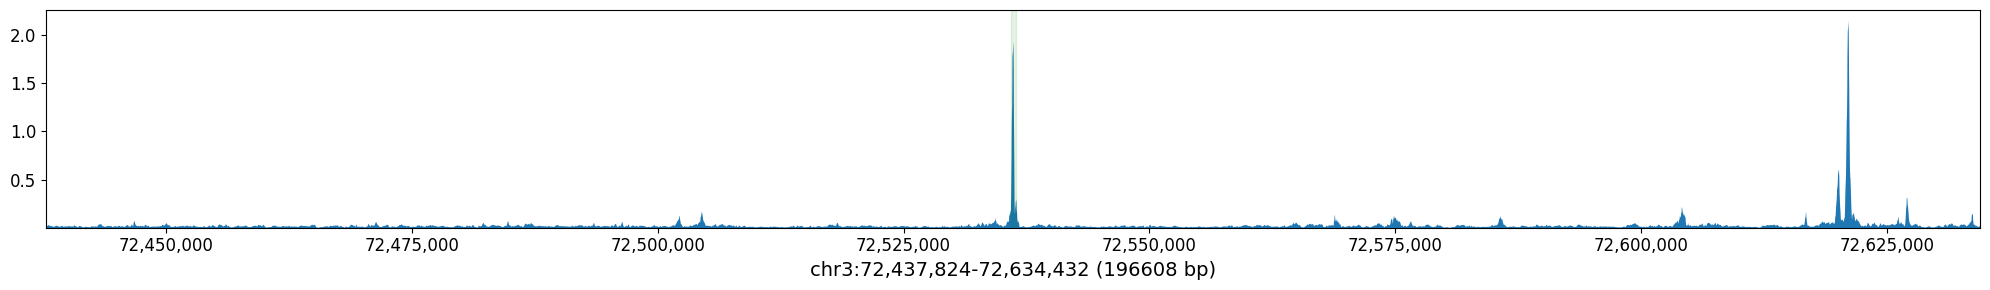

In [16]:
%matplotlib inline
class_idx = output_names_bp.index('ATAC:ITL23GL1') # Borzoi Prime Layer 2/3 neuron class

crested.pl.locus.track(
    prediction[0, :, class_idx],
    range = (chrom, start_borzoi_output, end_borzoi_output),
    show = False
)
plt.axvspan(start, end, color = 'green', alpha=0.1)
plt.show()

## Gene locus predictions

### With BICCN model

In [17]:
chrom = "chr4"
start = 91209533
end = 91374781

cell_type = "Sst"
class_idx = output_names_biccn.index(cell_type)

upstream = 50000
downstream = 25000

strand = "-"

scores, coordinates, min_loc, max_loc, tss_position = crested.tl.score_gene_locus(
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    target_idx=class_idx,
    model=model_biccn,
    strand=strand,
    upstream=upstream,
    downstream=downstream,
    step_size=100,
)

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

I0000 00:00:1765276425.849182 2221159 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 4 bytes spill stores, 4 bytes spill loads



19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 990ms/step


In [18]:
# Optional
bw_dir = Path("/staging/leuven/stg_00002/lcb/nkemp/mouse/biccn/bigwigs/bws/")
bw_path = bw_dir / f"{cell_type}.bw"

values = (
    crested.utils.read_bigwig_region(bw_path, (chrom, start - upstream, end + downstream))
    if strand == "+"
    else crested.utils.read_bigwig_region(bw_path, (chrom, start - downstream, end + upstream))
)
bw_values = values[0]
midpoints = values[1]

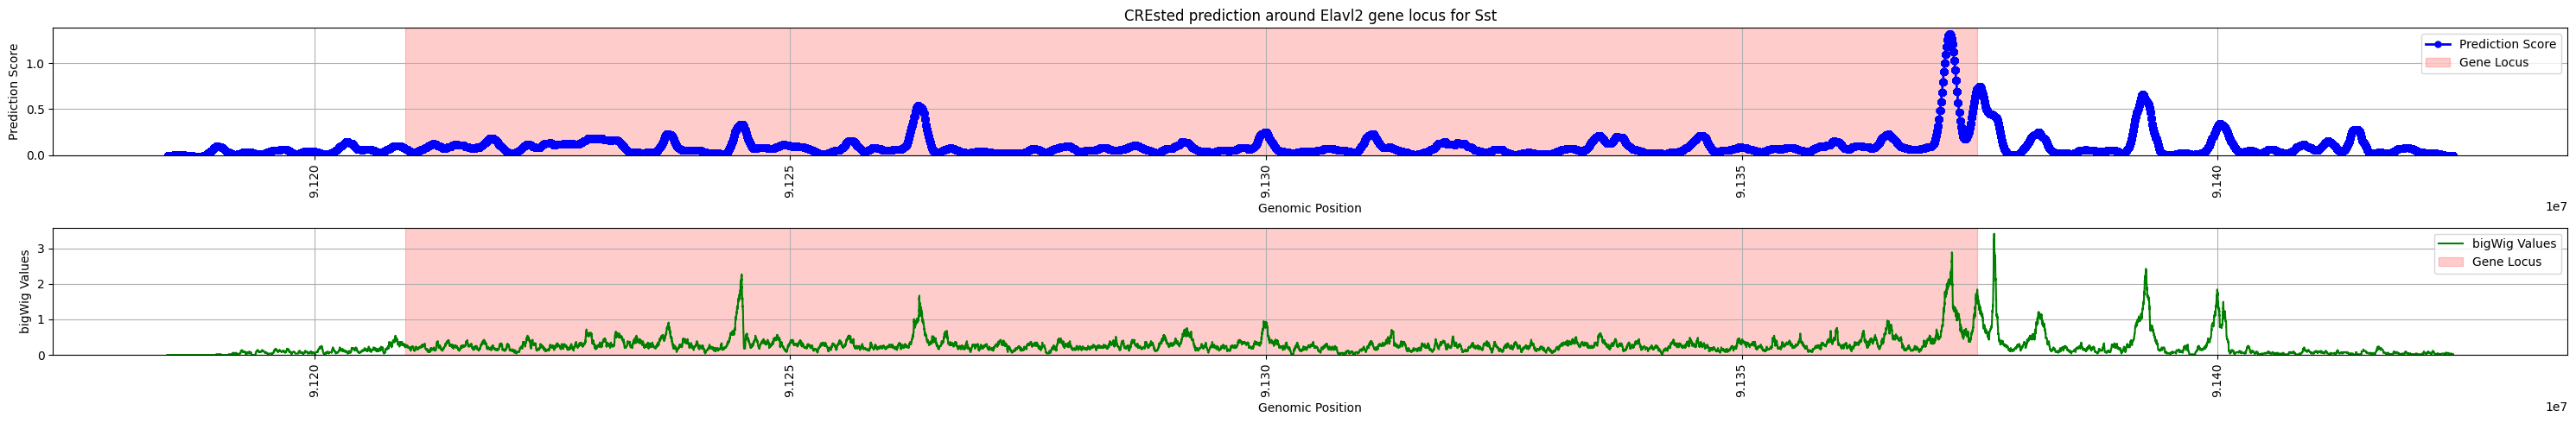

In [19]:
%matplotlib inline
crested.pl.locus.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    title="CREsted prediction around Elavl2 gene locus for Sst",
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
)

### With DeepMouseBrain3

In [20]:
scores, coordinates, min_loc, max_loc, tss_position = crested.tl.score_gene_locus(
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    target_idx=class_idx,
    model=model_dmb3,
    strand=strand,
    upstream=upstream,
    downstream=downstream,
    step_size=100,
)

I0000 00:00:1765276443.926470 2221216 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 388 bytes spill stores, 384 bytes spill loads

I0000 00:00:1765276444.172851 2221215 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 424 bytes spill stores, 416 bytes spill loads

I0000 00:00:1765276444.334866 2221214 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 2760 bytes spill stores, 2776 bytes spill loads



18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step

I0000 00:00:1765276521.321656 2221275 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 4664 bytes spill stores, 4128 bytes spill loads

I0000 00:00:1765276521.773757 2221275 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1765276521.879701 2221276 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 224 bytes spill stores, 132 bytes spill loads

I0000 00:00:1765276522.600248 2221276 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 640 bytes spill stores, 468 bytes spill loads



19/19 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step


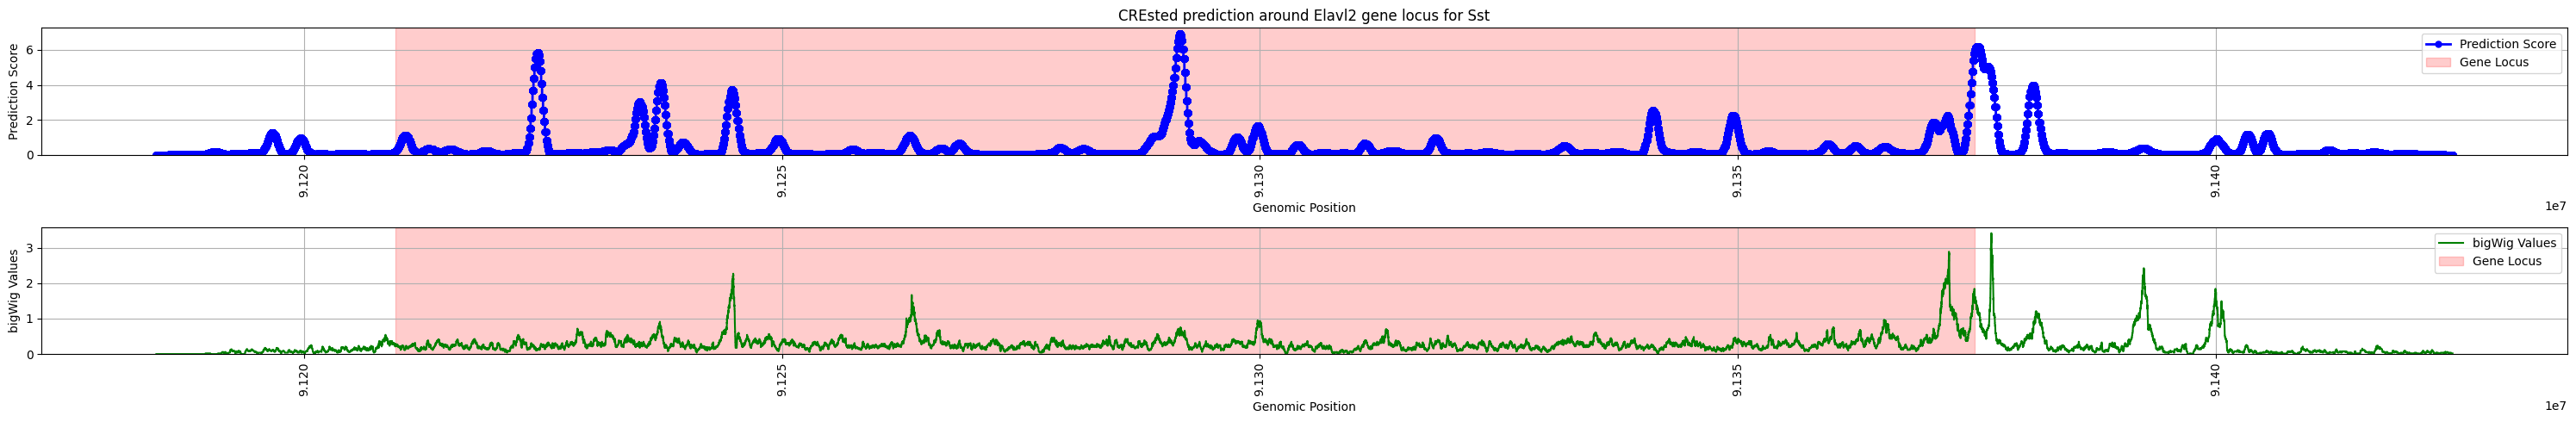

In [21]:
%matplotlib inline
crested.pl.locus.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    title="CREsted prediction around Elavl2 gene locus for Sst",
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
)